In [12]:
# Import packages
import numpy as np
import pandas as pd
from fastai.vision.all import *
from sklearn.model_selection import StratifiedKFold

In [13]:
# Import image labels
df = pd.read_csv('images/labels.csv')
df.head()

,files,label_specific,label_general,source
0,IMG_3788.JPEG,sweetclem,citrus,self
1,IMG_3789.JPEG,sweetclem,citrus,self
2,IMG_3790.JPEG,sweetclem,citrus,self
3,IMG_3791.JPEG,sweetclem,citrus,self
4,IMG_3792.JPEG,sweetclem,citrus,self


In [14]:
df['labels'] = df[['label_specific','label_general']].apply(
    lambda x: ' '.join(x.dropna().astype(str)),
    axis=1
)

In [15]:
# Setup image transforms
tfms = aug_transforms(size=224,flip_vert=True, max_rotate=25, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [16]:
'''skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=24)
conv_nets = [(resnet34,'resnet34'), (resnet50,'resnet50'), (resnet152,'resnet152'),
             (xresnet34,'xresnet34'), (xresnet50, 'xresnet50'), (xresnet152,'xresnet152'),
            (xresnet50_deeper,'xresnet50_deeper')]'''

"skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=24)\nconv_nets = [(resnet34,'resnet34'), (resnet50,'resnet50'), (resnet152,'resnet152'),\n             (xresnet34,'xresnet34'), (xresnet50, 'xresnet50'), (xresnet152,'xresnet152'),\n            (xresnet50_deeper,'xresnet50_deeper')]"

In [17]:
# Perform cross validtation AND select optimal underlying conv net
# Commented out since resnet152 was already determined to be the best fit for the data
'''results = []

for net, name in conv_nets:
    acc_val = []
    for train_index, val_index in skf.split(df.files, df.labels):
        d = df.copy()
        d.loc[:,'is_valid'] = 0
        d.loc[val_index, 'is_valid'] = 1
        # Load image data from image labels and jpg files
        dls = ImageDataLoaders.from_df(d, 'images', valid_col='is_valid', label_delim=' ',
                                   item_tfms=Resize(224), bs=64, batch_tfms=tfms)
        learn = cnn_learner(dls, net, metrics=partial(accuracy_multi, thresh=0.5))
        learn.fine_tune(1)
        loss, acc = learn.validate()
        acc_val.append(acc)
    results.append([name, np.mean(acc_val)])'''

"results = []\n\nfor net, name in conv_nets:\n    acc_val = []\n    for train_index, val_index in skf.split(df.files, df.labels):\n        d = df.copy()\n        d.loc[:,'is_valid'] = 0\n        d.loc[val_index, 'is_valid'] = 1\n        # Load image data from image labels and jpg files\n        dls = ImageDataLoaders.from_df(d, 'images', valid_col='is_valid', label_delim=' ',\n                                   item_tfms=Resize(224), bs=64, batch_tfms=tfms)\n        learn = cnn_learner(dls, net, metrics=partial(accuracy_multi, thresh=0.5))\n        learn.fine_tune(1)\n        loss, acc = learn.validate()\n        acc_val.append(acc)\n    results.append([name, np.mean(acc_val)])"

In [18]:
#print(results)

In [19]:
# Load image data from image labels and jpg files
dls = ImageDataLoaders.from_df(df[['files','labels']], 'images', valid_pct=0.2, label_delim=' ',
                               item_tfms=Resize(224), bs=32, batch_tfms=tfms)
dls.valid_ds.items

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


,files,labels
864,pl_braeburnr_104_100.jpg,pink_lady apple
421,braeburnr_132_100.jpg,braeburn apple
794,pl_braeburn30_100.jpg,pink_lady apple
1084,pl_braeburnr_98_100.jpg,pink_lady apple
933,pl_braeburnr_167_100.jpg,pink_lady apple
...,...,...
930,pl_braeburnr_164_100.jpg,pink_lady apple
1170,navel_orangebraeburn175_100.jpg,navel_orange citrus
684,pl_braeburn148_100.jpg,pink_lady apple
376,braeburn313_100.jpg,braeburn apple


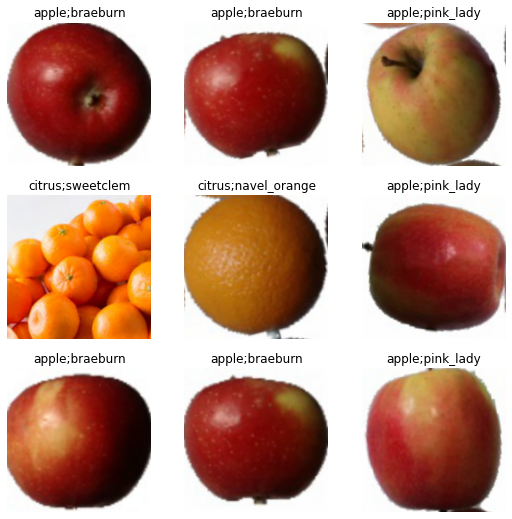

In [20]:
# Preview data
dls.show_batch()

In [21]:
# Init learner; use resnet50 as the starting point for this CNN
learn = cnn_learner(dls, resnet152, metrics=partial(accuracy_multi, thresh=0.5), model_dir='models')

SuggestedLRs(valley=0.0008317637839354575)

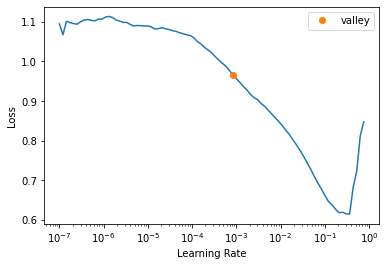

In [22]:
# Calc optimal learning rate
learn.lr_find()

In [23]:
# Train model
learn.fine_tune(8, 0.001)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.708213,0.413079,0.785101,15:12


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.513657,0.366341,0.815152,18:22
1,0.471320,0.304152,0.881566,18:20
2,0.416374,0.243518,0.943434,18:26
3,0.355348,0.192656,0.971970,18:41
4,0.293029,0.139057,0.992424,18:24
5,0.245255,0.124126,0.993939,18:25
6,0.215953,0.107425,0.994950,18:16
7,0.197664,0.105686,0.995202,18:24


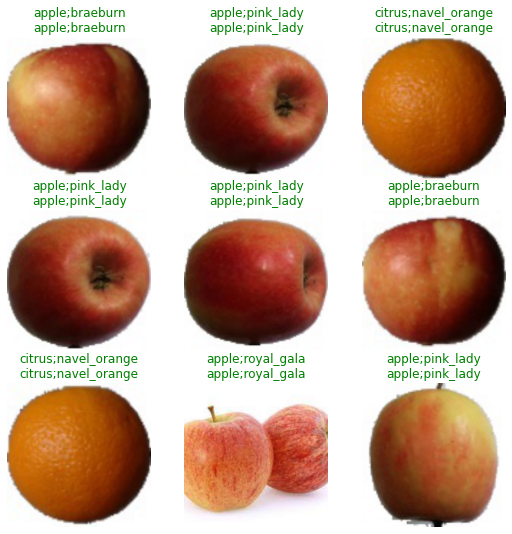

In [24]:
# Preview results
learn.show_results()

,target,predicted,probabilities,loss
0,apple;pink_lady,apple;braeburn,"TensorBase([[9.9952e-01, 9.4927e-01, 2.0640e-04, 2.7018e-01, 1.7248e-01, 1.7431e-01,\n 5.2947e-04, 3.6448e-01, 1.9581e-01, 1.1235e-01, 2.0998e-01, 1.2070e-01],\n [1.0057e-04, 3.1252e-03, 9.9904e-01, 9.7909e-02, 1.0937e-01, 9.7118e-02,\n 9.8411e-01, 1.7779e-01, 7.4161e-02, 3.7317e-03, 1.8474e-01, 6.4087e-01],\n [9.9779e-01, 4.1039e-02, 2.9794e-03, 1.1386e-01, 1.9350e-01, 1.3226e-01,\n 3.4415e-04, 2.5211e-01, 1.1176e-01, 2.7729e-01, 8.8566e-01, 3.1598e-01],\n [9.9900e-01, 8.9696e-01, 6.9521e-04, 1.0982e-01, 1.6910e-01, 1.7491e-01,\n 8.3070e-04, 2.4779e-01, 1.3151e-01, 6.2094e-03, 7.7506e-01, 1.7359e-01],\n [9.9638e-01, 1.2756e-02, 2.0963e-03, 4.1773e-01, 2.2128e-01, 1.3811e-01,\n 5.4601e-03, 1.1168e-01, 3.2207e-02, 3.2254e-01, 7.0653e-01, 1.3157e-01],\n [9.9690e-01, 6.3205e-02, 2.5382e-03, 5.4054e-01, 1.4873e-01, 1.6065e-01,\n 7.1076e-03, 1.1048e-01, 1.2093e-01, 2.7687e-01, 3.3228e-01, 7.4544e-02],\n [9.8906e-01, 7.6477e-01, 2.2582e-03, 3.3889e-01, 1.3171e-01, 3.1583e-01,\n 1.3011e-03, 2.1958e-01, 1.0523e-01, 4.9065e-03, 7.0013e-01, 2.9882e-01],\n [2.8181e-02, 9.4396e-05, 8.9231e-01, 7.6769e-01, 1.8665e-01, 2.1634e-01,\n 4.8379e-03, 1.1824e-01, 6.7193e-02, 1.1716e-04, 4.0563e-01, 9.9701e-01],\n [9.9942e-01, 3.4869e-01, 1.3845e-03, 3.6595e-01, 2.2187e-01, 1.7780e-01,\n 7.0378e-03, 1.4010e-01, 7.7322e-02, 4.5357e-02, 2.6274e-01, 1.3241e-01]])",0.5749918818473816


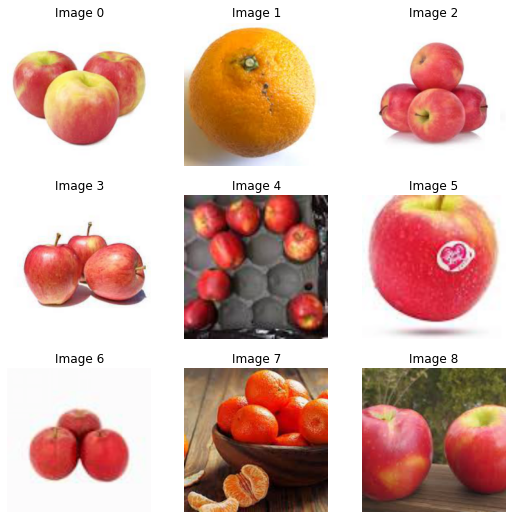

In [25]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9)

In [26]:
learn.save('model1.pkl')

Path('images/models/model1.pkl.pth')

In [28]:
learn.predict('images/12-12-2021_IMG_3855.JPEG')

((#2) ['crossiant_plain','pastery'],
 TensorBase([False, False, False, False, False,  True, False, False,  True, False,
         False, False]),
 TensorBase([0.0022, 0.0087, 0.0011, 0.1180, 0.1251, 0.9120, 0.0057, 0.2162, 1.0000,
         0.0017, 0.0774, 0.0701]))